# FACEBOOK DATA FROM YAHOO FINANCE

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("C:/Users/ASUS/Desktop/FMI/Licenta OB/Overall Code/packtpub-src/csv/FB.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-05-30,151.970001,152.899994,151.639999,152.380005,152.380005,13226000
1,2017-05-31,152.699997,153.350006,151.089996,151.460007,151.460007,18023900
2,2017-06-01,151.750000,152.289993,150.300003,151.529999,151.529999,14530600
3,2017-06-02,151.850006,153.630005,151.300003,153.610001,153.610001,16854400
4,2017-06-05,153.639999,154.710007,153.410004,153.630005,153.630005,12520400


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
497,2019-05-21,184.570007,185.699997,183.889999,184.820007,184.820007,7502800
498,2019-05-22,184.729996,186.740005,183.610001,185.320007,185.320007,9213800
499,2019-05-23,182.419998,183.899994,179.669998,180.869995,180.869995,12768800
500,2019-05-24,182.330002,183.630005,180.830002,181.059998,181.059998,8807700
501,2019-05-28,181.539993,184.710007,181.449997,184.309998,184.309998,14832200


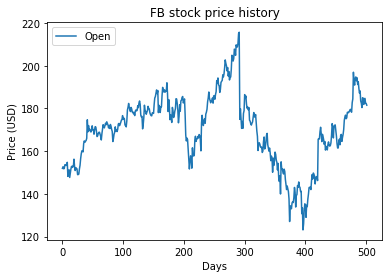

In [5]:
plt.figure()
plt.title("FB stock price history")
plt.plot(df['Open'])
#plt.plot(df["Close"])
#plt.plot(df["High"])
#plt.plot(df["Low"])
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open', 'Close', 'High', 'Low'], loc='upper left')
plt.show()

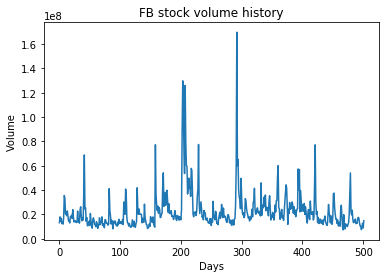

In [6]:
plt.figure()
plt.plot(df['Volume'])
plt.title('FB stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [7]:
print('Checking if any null values are present\n', df.isna().sum())

Checking if any null values are present
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


### Normalizing the data
* Split the data into train, test
* Normalize
* Covert the DataFrame to ndarray

In [8]:
#! pip install keras

In [9]:
#! pip install np_utils

In [10]:
#! pip install tensorflow

In [11]:
#! pip install numpy --upgrade --user

In [12]:
from tqdm._tqdm_notebook import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras import optimizers
from keras import backend as K

print('Checking GPU available', K.tensorflow_backend._get_available_gpus())


Using TensorFlow backend.


Checking GPU available []


In [21]:
from keras import losses

In [13]:
TIME_STEPS = 60
BATCH_SIZE = 20

In [14]:
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 60
}

In [15]:

train_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print('Train and test set', len(df_train), len(df_test))

#scale the feature MinMax, build array
x = df_train.loc[:, train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:, train_cols])

Train and test set 401 101


In [16]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total nb of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    
    print('length of time-series i/o', x.shape, y.shape)
    return x, y

In [17]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that is divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0] % batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [18]:
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)

x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE), 2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE), 2)


length of time-series i/o (341, 60, 5) (341,)



length of time-series i/o (41, 60, 5) (41,)


In [27]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, time_steps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                       dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                       kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20, activation='relu'))
    lstm_model.add(Dense(1, activation='linear'))
    optimizer = optimizers.RMSprop(lr=params['lr'])
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    # lstm_model.compile(loss=losses.mean_squarred_error, optimizer=optimizer)
    return lstm_model

In [28]:
model = create_model()

#csv_logger = CSVLogger()

history = model.fit(x_t, y_t, epochs=params['epochs'], verbose=2, batch_size=BATCH_SIZE,
                   shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE), 
                                                   trim_dataset(y_val, BATCH_SIZE))) #,callbacks=[es, mcp, csv_logger]

Instructions for updating:
Use tf.cast instead.
Train on 340 samples, validate on 20 samples
Epoch 1/300
 - 3s - loss: 0.2736 - val_loss: 0.2635
Epoch 2/300
 - 1s - loss: 0.1720 - val_loss: 0.1330
Epoch 3/300
 - 1s - loss: 0.0628 - val_loss: 0.0342
Epoch 4/300
 - 1s - loss: 0.0265 - val_loss: 0.0294
Epoch 5/300
 - 1s - loss: 0.0279 - val_loss: 0.0257
Epoch 6/300
 - 1s - loss: 0.0249 - val_loss: 0.0246
Epoch 7/300
 - 1s - loss: 0.0236 - val_loss: 0.0263
Epoch 8/300
 - 1s - loss: 0.0248 - val_loss: 0.0264
Epoch 9/300
 - 1s - loss: 0.0222 - val_loss: 0.0263
Epoch 10/300
 - 1s - loss: 0.0215 - val_loss: 0.0281
Epoch 11/300
 - 1s - loss: 0.0212 - val_loss: 0.0278
Epoch 12/300
 - 1s - loss: 0.0221 - val_loss: 0.0280
Epoch 13/300
 - 1s - loss: 0.0196 - val_loss: 0.0253
Epoch 14/300
 - 1s - loss: 0.0179 - val_loss: 0.0279
Epoch 15/300
 - 1s - loss: 0.0206 - val_loss: 0.0246
Epoch 16/300
 - 1s - loss: 0.0204 - val_loss: 0.0268
Epoch 17/300
 - 1s - loss: 0.0160 - val_loss: 0.0251
Epoch 18/300
 -

Epoch 149/300
 - 1s - loss: 0.0065 - val_loss: 0.0081
Epoch 150/300
 - 1s - loss: 0.0077 - val_loss: 0.0103
Epoch 151/300
 - 1s - loss: 0.0068 - val_loss: 0.0085
Epoch 152/300
 - 1s - loss: 0.0071 - val_loss: 0.0071
Epoch 153/300
 - 1s - loss: 0.0074 - val_loss: 0.0083
Epoch 154/300
 - 1s - loss: 0.0070 - val_loss: 0.0072
Epoch 155/300
 - 1s - loss: 0.0066 - val_loss: 0.0097
Epoch 156/300
 - 1s - loss: 0.0067 - val_loss: 0.0076
Epoch 157/300
 - 1s - loss: 0.0063 - val_loss: 0.0093
Epoch 158/300
 - 1s - loss: 0.0069 - val_loss: 0.0076
Epoch 159/300
 - 1s - loss: 0.0061 - val_loss: 0.0084
Epoch 160/300
 - 1s - loss: 0.0066 - val_loss: 0.0065
Epoch 161/300
 - 1s - loss: 0.0069 - val_loss: 0.0082
Epoch 162/300
 - 1s - loss: 0.0066 - val_loss: 0.0084
Epoch 163/300
 - 1s - loss: 0.0062 - val_loss: 0.0084
Epoch 164/300
 - 1s - loss: 0.0063 - val_loss: 0.0095
Epoch 165/300
 - 1s - loss: 0.0067 - val_loss: 0.0084
Epoch 166/300
 - 1s - loss: 0.0061 - val_loss: 0.0076
Epoch 167/300
 - 1s - loss: 

In [33]:
print(history.history.keys())
print(history.history['val_loss'])

dict_keys(['val_loss', 'loss'])
[0.2634792923927307, 0.13295379281044006, 0.03419623151421547, 0.0293503999710083, 0.025684842839837074, 0.02460877038538456, 0.02634914591908455, 0.026412907987833023, 0.02625003457069397, 0.028121571987867355, 0.027795348316431046, 0.02798141911625862, 0.02526862919330597, 0.027867551892995834, 0.024572253227233887, 0.02676217630505562, 0.02512986585497856, 0.02476954087615013, 0.02285853400826454, 0.02543490007519722, 0.022440288215875626, 0.026431003585457802, 0.0228811614215374, 0.021371470764279366, 0.02103440649807453, 0.02298203483223915, 0.02127932570874691, 0.019365016371011734, 0.020580729469656944, 0.018236428499221802, 0.016655439510941505, 0.020582670345902443, 0.020115628838539124, 0.01964038610458374, 0.022320080548524857, 0.02052079513669014, 0.02148522436618805, 0.021182861179113388, 0.020090926438570023, 0.01734462007880211, 0.020324330776929855, 0.018838126212358475, 0.01746700517833233, 0.0176860298961401, 0.01555284857749939, 0.0181

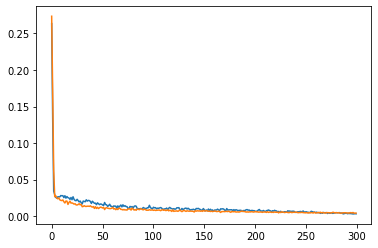

In [37]:
plt.figure()
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])